In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from scipy.spatial import distance

In [2]:
import matplotlib.pyplot as plt

In [3]:
user_path = "./0422_rf_edition/xr_users_classified_0422_wprob.csv"
user_prob_path = "./0422_rf_edition/xr_users_classified_0704_four_methods_wprob.csv"
tweet_path = "tweet_table_xr_2019_0621_fixed.csv"
tweet_topic_modelled = "./NLP/text_classified.csv"

In [ ]:
bot_classification_col = "is_bot_botometer"
suffix = "_botometer_0.5"

## Generate users w/ bot interaction

### Filtering communications

In [5]:
#Preprocessing
users = pd.read_csv(user_path, lineterminator='\n')
users_prob = pd.read_csv(user_prob_path, lineterminator='\n')
df = pd.read_csv(tweet_path)
tweet_classified = pd.read_csv(tweet_topic_modelled, lineterminator='\n')

/tmp/ipykernel_203268/1195143438.py:4: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tweet_path)


In [6]:
users = users.merge(users_prob[["id","is_bot_xgb","is_bot_xgb_prob","is_bot_botometer_prob"]], on = "id", how = "left")

In [7]:
#Filtering out tweet not related to XR like iphone sellers
df = df[~df["text"].str.contains("(?i)iphone")]
df = df[~df["text"].str.contains("(?i)phone")]
df = df[~df["text"].str.contains("(?i)max")]
df = df[~df["text"].str.contains("(?i)11")]
df = df[~df["text"].str.contains("(?i)vr")]
df = df[~df["text"].str.contains("(?i)xpel")]
df = df[~df["text"].str.contains("(?i)tint")]
#text = df["text"]

In [8]:
df_original = df.copy() # keep a copy for further analysis

In [9]:
df['created_at_dt'] = pd.to_datetime(df.created_at, infer_datetime_format=True)
users['created_at_dt'] = pd.to_datetime(users.created_at, infer_datetime_format=True)

/tmp/ipykernel_203268/1608327253.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['created_at_dt'] = pd.to_datetime(df.created_at, infer_datetime_format=True)
/tmp/ipykernel_203268/1608327253.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  users['created_at_dt'] = pd.to_datetime(users.created_at, infer_datetime_format=True)
/tmp/ipykernel_203268/1608327253.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  u

In [10]:
prob_col = "is_bot_botometer_prob"

In [11]:
df = df.merge(users[[prob_col,'id']], how = 'left', left_on = 'author_id', right_on = 'id', copy = False)

In [12]:
df.dropna(subset = [prob_col], inplace = True)

In [13]:
def filtering_interactions(prob_col, threshold, df):
    df = df[df.referenced_tweets_0_type != "retweeted"]
    bot_classification_col = "_".join(prob_col.split("_")[:-1])
    
    df = df.merge(tweet_classified, how = 'left', left_on = "text", right_on = "text", copy = False)

    df_comm = df.merge(users[[prob_col, 'id']], how = 'left', left_on = 'in_reply_to_user_id', right_on = 'id', suffixes=('', '_reply'))
    #print(df_comm.columns)
    df_comm[bot_classification_col] = [1 if i>threshold else 0 for i in df_comm[prob_col]]
    df_comm[bot_classification_col+"_reply"] = [1 if i>threshold else 0 for i in df_comm[prob_col+"_reply"]]
    reply_df = df_comm[(df_comm[bot_classification_col+"_reply"] == 1) & (df_comm[bot_classification_col] == 0)]
    return reply_df, df_comm

def generate_matching(reply_df, original_df, threshold, prob_col = "is_bot_botometer_prob"):
    reply_df_short = reply_df[["author_id", "conversation_id", "created_at"]]
    
    bot_classification_col = "_".join(prob_col.split("_")[:-1])
    original_df[bot_classification_col] = [1 if i>threshold else 0 for i in original_df[prob_col]]
    
    original_df = original_df[(original_df[bot_classification_col] == 0) & (original_df.referenced_tweets_0_type != "replied_to")]
    #reply_df_short['created_at_dt'] = pd.to_datetime(reply_df_short.created_at, infer_datetime_format=True)
    original_df['created_at_rough'] = [i[:-9] for i in original_df.created_at]
    reply_df_short['created_at_rough'] = [i[:-9] for i in reply_df_short.created_at]
    matched_records = original_df.merge(reply_df_short, how = 'right', on = "created_at_rough", copy = False)
    matched_records = matched_records[matched_records.author_id_x != matched_records.author_id_y]
    matched_uids = matched_records[["author_id_x", "author_id_y", "created_at_x","created_at_y"]]
    matched_uids.columns = ['matched_user', "user", "interaction_matched", "interaction"]
    return matched_uids

In [15]:
thresholds = [i/100 for i in range(0,90,5)]

In [ ]:
bot_pct = []
num_users = []
total_user_records = []
num_for_matching = []
total_for_matching_records = []
for threshold in thresholds:
    bot_pct.append(sum([1 if i>threshold else 0 for i in users["is_bot_botometer_prob"]])/users.shape[0])
    reply_df = filtering_interactions("is_bot_botometer_prob", threshold, df)[0]
    matched_df = generate_matching(reply_df, df, threshold)
    num_users.append(len(set(reply_df.author_id)))
    total_user_records.append(reply_df.shape[0])
    num_for_matching.append(len(set(matched_df.matched_user)))
    total_for_matching_records.append(matched_df.shape[0])

In [19]:
bot_pct

[0.891566265060241,
 0.891566265060241,
 0.891566265060241,
 0.891566265060241,
 0.891566265060241,
 0.8587614897279086,
 0.7904786318526386,
 0.7300179441168931,
 0.5734939759036145,
 0.5278060570549676,
 0.5075841359358406,
 0.4701138902113011,
 0.4365693778152122,
 0.39055187314607975,
 0.3490606804116161,
 0.28936170212765955,
 0.09645878346211594,
 0.03368367085362727]

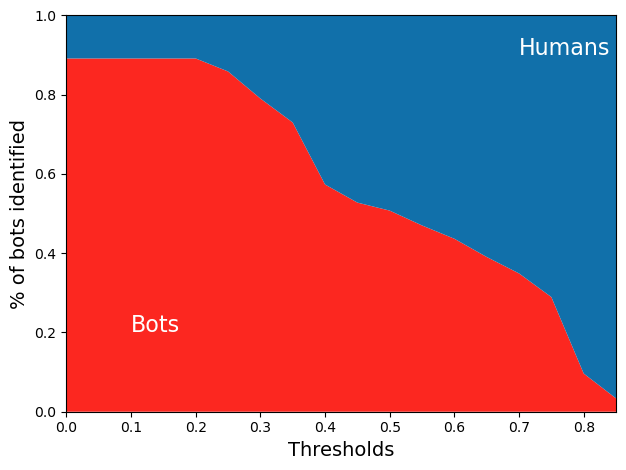

In [23]:
human_pct = [1-i for i in bot_pct]
color_map = ["#fc2720", "#1170aa"]
plt.stackplot(thresholds,bot_pct,human_pct, colors = color_map)
plt.ylabel('% of bots identified',fontsize = 14)
plt.xlabel('Thresholds',fontsize = 14)
plt.xlim(0,0.85)
plt.ylim(0,1)
plt.text(0.1, 0.2, 'Bots', fontsize=16, color='white')
plt.text(0.7, 0.9, 'Humans', fontsize=16, color='white')
plt.tight_layout()
plt.savefig("./botometer_based_svg/bot_pct_by_threshold_all.png")

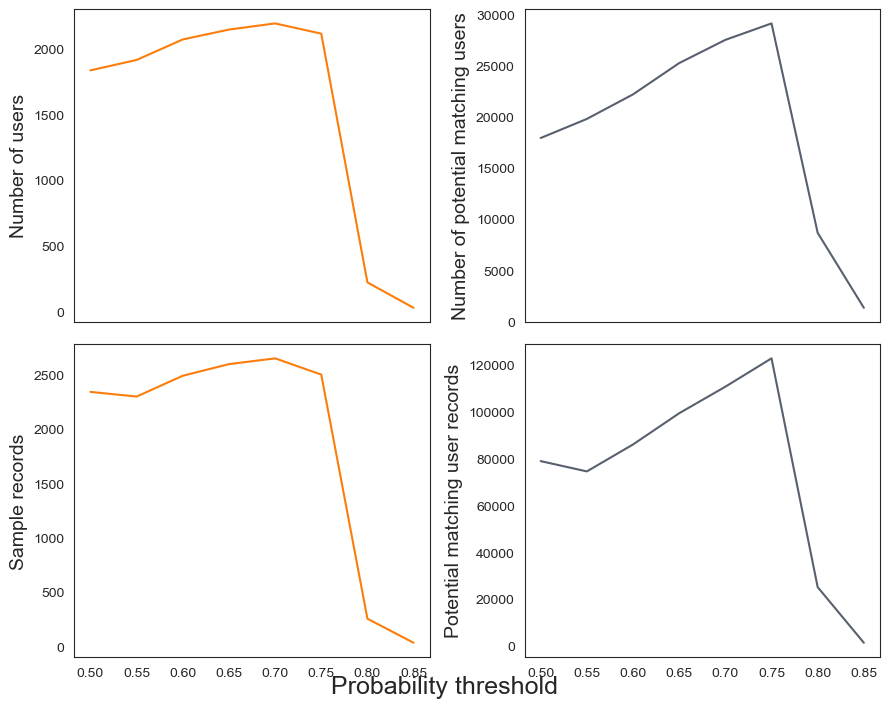

In [21]:
import seaborn as sns
sns.set_style("white")
fig, axs = plt.subplots(2, 2, figsize = (9,7), sharex = True)

# Plot the subfigures
axs[0, 0].plot(thresholds,num_users, color = "#fc7d0b")
axs[0, 0].set_ylabel('Number of users',fontsize = 14)
axs[0, 1].plot(thresholds,num_for_matching, color = "#57606c")
axs[0, 1].set_ylabel('Number of potential matching users',fontsize = 14)
axs[1, 0].plot(thresholds,total_user_records, color = "#fc7d0b")
axs[1, 0].set_ylabel('Sample records',fontsize = 14)

axs[1, 1].plot(thresholds,total_for_matching_records, color = "#57606c")
axs[1, 1].set_ylabel('Potential matching user records',fontsize = 14)
fig.text(0.5, 0.001, 'Probability threshold', ha='center',fontsize = 18)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
#plt.show()
plt.savefig("./botometer_based_svg/num_users_by_threshold_0,5.png")

In [22]:
reply_df,df_comm = filtering_interactions("is_bot_botometer_prob", 0.5, df)
potential_matched = generate_matching(reply_df, df, 0.5)

/tmp/ipykernel_5776/1472611243.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df['created_at_rough'] = [i[:-9] for i in original_df.created_at]
/tmp/ipykernel_5776/1472611243.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_df_short['created_at_rough'] = [i[:-9] for i in reply_df_short.created_at]


In [23]:
reply_df.author_id

31                1373638237
62                3054589951
101               2434032380
133               1107264246
150               1620962233
                ...         
42401     851134347998625794
42420             2281786801
42492               91564001
42509             2357434362
42512    1149280708701110272
Name: author_id, Length: 2339, dtype: int64

In [24]:
reply_df[reply_df.author_id == 2059811]

,text,conversation_id,author_id,id_x,created_at,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count,public_metrics_quote_count,possibly_sensitive,...,referenced_tweets_1_id,referenced_tweets_1_id_hydrate_author_id,created_at_dt,is_bot_botometer_prob,id_y,is_bot_botometer,topic,is_bot_botometer_prob_reply,id,is_bot_botometer_reply
22893,"@XR_NYC Didn't buy anything today, but I do se...",1200436460509421574,2059811,1200612972122390528,2019-11-30T03:10:13.000Z,0,1,1,0,False,...,NaN,NaN,2019-11-30 03:10:13+00:00,0.306188,2059811.0,0,7.0,0.766877,1.081287e+18,1


In [25]:
potential_matched = potential_matched.drop_duplicates(subset = ['matched_user'])

In [26]:
len(set(potential_matched.user))

1099

In [28]:
reply_df.to_csv(f"./botometer/xr2019_user_reply_bots{suffix}.csv", index = False)
df_comm.to_csv(f'./botometer/df_comm_edges{suffix}.csv', index = False)
potential_matched.to_csv(f"./botometer/xr2019_user_matched_rough{suffix}.csv", index = False)

In [29]:
bot_post_id = [i if i is not None else j for i,j in zip(reply_df.referenced_tweets_0_id, reply_df.referenced_tweets_1_id)]
bot_post_id = [str(int(i)) for i in bot_post_id if str(i) != "nan"] # Saving the ids of bot posts

In [31]:
with open('./botometer/bot_conversation_id_0.5.txt', 'w') as f:
    for line in bot_post_id:
        f.write(str(line))
        f.write('\n')

## Creating table for data collection

In [32]:
# Calculate the 60 day time range before & after interaction for data collection
user_time = users.merge(reply_df[["author_id", "created_at", "text"]], how = 'inner', left_on = "id", right_on = "author_id", copy = False)
user_time = user_time[['author_id','created_at_x', 'created_at_y', 'text']]
user_time.columns = ['author_id', 'user_created_at', 'interaction_at', 'text']
user_time = user_time.drop_duplicates(subset = ['author_id'])
user_time['user_created_at'] = pd.to_datetime(user_time.user_created_at, infer_datetime_format=True)
user_time['interaction_at'] = pd.to_datetime(user_time.interaction_at, infer_datetime_format=True)
time_window = timedelta(days = 30)
user_time['time_start'] = user_time.interaction_at - time_window
user_time['time_end'] = user_time.interaction_at + time_window

/tmp/ipykernel_5776/4257656431.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  user_time['user_created_at'] = pd.to_datetime(user_time.user_created_at, infer_datetime_format=True)
/tmp/ipykernel_5776/4257656431.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  user_time['user_created_at'] = pd.to_datetime(user_time.user_created_at, infer_datetime_format=True)
/tmp/ipykernel_5776/4257656431.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can sa

In [33]:
user_time['time_start_str'] = [i.strftime("%Y-%m-%dT%H:%M:%SZ") for i in user_time.time_start]
user_time['time_end_str'] = [i.strftime("%Y-%m-%dT%H:%M:%SZ") for i in user_time.time_end]

In [34]:
user_time.to_csv(f"./botometer/matching_user_data_collection_xr2019{suffix}.csv", index = False)

## Filtering by eculid

In [35]:
users = users[users.created_at != "0"]
#users.dropna(subset = ['created_at'], inplace = True)
#users['created_at_dt'] = pd.to_datetime(users.created_at, format = "%a %b %d %H:%M:%S +0000 %Y ", errors = 'coerce')

In [36]:
potential_matched = potential_matched.drop_duplicates(subset = ['matched_user'])
euclid = pd.DataFrame(columns = ['uid', "matched_uid", "euclid"])
cols = ['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'followers_growth', 'friends_growth', 'favourites_growth',
       'listed_growth', 'follower_friend_ratio']


In [ ]:
uids = []
matched_user = []
eculid = []
for i in range(potential_matched.shape[0]):
    uid = potential_matched.iloc[i].user
    matched_uid = potential_matched.iloc[i].matched_user
    user_info = users[users.id == uid][cols]
    matched_info = users[users.id == matched_uid][cols]
    if user_info.shape[0] == 1 and matched_info.shape[0] == 1:
        user_info = [np.log(float(i)+1) for i in list(user_info.T.iloc[:,0])]

        matched_info = [np.log(float(i) + 1) for i in list(matched_info.T.iloc[:,0])]

        X = np.vstack([user_info, matched_info])
        euclidean_ = distance.pdist(X)[0]
        uids.append(uid)
        eculid.append(euclidean_)
        matched_user.append(matched_uid)
    else:
        pass



In [38]:
eculid_df = pd.DataFrame()
eculid_df['uid'] = uids
eculid_df['eculid'] = eculid
eculid_df['matched_uid'] = matched_user

In [39]:
eculid_df.sort_values(by = ['uid', 'eculid'], ascending = [True, False], inplace = True)

In [40]:
matched_with_euclid = eculid_df.merge(potential_matched, right_on = 'matched_user', left_on = 'matched_uid', how = 'left', copy = False)
matched_with_euclid.dropna(subset = ['matched_user'], inplace = True)
matched_with_euclid['interaction_matched'] = pd.to_datetime(matched_with_euclid.interaction_matched, infer_datetime_format=True)
time_window = timedelta(days = 30)
matched_with_euclid['time_start'] = matched_with_euclid.interaction_matched - time_window
matched_with_euclid['time_end'] = matched_with_euclid.interaction_matched + time_window
matched_with_euclid.to_csv(f"./botometer/xr2019_user_matched_with_euclid{suffix}.csv", index = False)

/tmp/ipykernel_5776/2322026377.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  matched_with_euclid['interaction_matched'] = pd.to_datetime(matched_with_euclid.interaction_matched, infer_datetime_format=True)


In [ ]:
# Getting first best match
firsts = matched_with_euclid.drop_duplicates(subset=['uid'], keep='first')
firsts['time_start'] = pd.to_datetime(firsts.time_start, infer_datetime_format=True)
firsts['time_end'] = pd.to_datetime(firsts.time_end, infer_datetime_format=True)
firsts['time_start_str'] = [i.strftime("%Y-%m-%dT%H:%M:%SZ") for i in seconds.time_start]
firsts['time_end_str'] = [i.strftime("%Y-%m-%dT%H:%M:%SZ") for i in seconds.time_end]
firsts.to_csv(f"./xr2019_user_matched_firsts{suffix}.csv", index = False)

In [41]:
## Getting second best match
seconds = matched_with_euclid.groupby('uid').head(2)
seconds['uid'] = [str(int(i)) for i in seconds.uid]
seconds['matched_uid'] = [str(int(i)) for i in seconds.matched_uid]
seconds['matched_user'] = [str(int(i)) for i in seconds.matched_user]
seconds['time_start'] = pd.to_datetime(seconds.time_start, infer_datetime_format=True)
seconds['time_end'] = pd.to_datetime(seconds.time_end, infer_datetime_format=True)
seconds['time_start_str'] = [i.strftime("%Y-%m-%dT%H:%M:%SZ") for i in seconds.time_start]
seconds['time_end_str'] = [i.strftime("%Y-%m-%dT%H:%M:%SZ") for i in seconds.time_end]
seconds.to_csv(f"./botometer/xr2019_user_matched_fifths{suffix}.csv", index = False)

/tmp/ipykernel_5776/2001993493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seconds['uid'] = [str(int(i)) for i in seconds.uid]
/tmp/ipykernel_5776/2001993493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seconds['matched_uid'] = [str(int(i)) for i in seconds.matched_uid]
/tmp/ipykernel_5776/2001993493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

## bot original stuff

In [54]:
def load_token(textfile):
    try:
        with open(textfile, 'r') as file:
            auth = file.readlines()
            keys = []
            for i in auth:
                i = str(i).strip()
                keys.append(i)
        return keys
    except EnvironmentError:
        print('Error loading access token from file')

In [56]:
conversation = load_token("./botometer/bot_conversation_id_0.5.txt")

In [57]:
all_tweets = pd.read_csv(tweet_path)

/tmp/ipykernel_5776/4130662692.py:1: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  all_tweets = pd.read_csv(tweet_path)


In [58]:
conversation = [int(i) for i in conversation]

In [59]:
bot_original_tweet = all_tweets.merge(pd.DataFrame({"id":conversation}),on="id")

In [60]:
bot_original_tweet.shape[0]

285

In [61]:
bot_original_tweet

,text,conversation_id,author_id,id,created_at,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count,public_metrics_quote_count,possibly_sensitive,...,in_reply_to_user_id_hydrate_location,referenced_tweets_0_id_hydrate_geo_place_id,conversation_id_hydrate_referenced_tweets_0_type,conversation_id_hydrate_referenced_tweets_0_id,geo_place_id,conversation_id_hydrate_geo_place_id,id_hydrate_geo_place_id,referenced_tweets_1_type,referenced_tweets_1_id,referenced_tweets_1_id_hydrate_author_id
0,Eyewitness: @SkyAndyHughes spent two months em...,1195273621780025344,7587032,1195273621780025344,2019-11-15T09:33:33.000Z,13,17,24,6,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Just wanted to give a shout out and #ff to the...,1195274542442258432,216692192,1195274542442258432,2019-11-15T09:37:12.000Z,12,1,24,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Went to the Luton Airport expansion consultati...,1195315133708455936,914488810616082432,1195315133708455936,2019-11-15T12:18:30.000Z,1,1,2,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,@AnneNotley1 @JackMilln @DoctorsXr @Scientists...,1195373744941944832,229016226,1195378001552297984,2019-11-15T16:28:19.000Z,0,2,6,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,‘It’s our aim to polarise the public' - Roman ...,1195415231352233984,7587032,1195415231352233984,2019-11-15T18:56:15.000Z,8,37,19,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,@technobaboo @alfredo_xr Exactly. Some logic ...,1205143583797530627,70596949,1205158583874310144,2019-12-12T16:12:51.000Z,0,1,3,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,@EditorScribble @xr_seq It's not even 8am yet ...,1205242144933302272,473714282,1205245354641215488,2019-12-12T21:57:39.000Z,0,1,1,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,@EditorScribble @xr_seq I love that 150+ peopl...,1205242144933302272,473714282,1205248322874691584,2019-12-12T22:09:27.000Z,0,1,1,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,@XR_CrazedBear @malechk_ @Callux Hahahahaha ch...,1205246535484751875,2156634053,1205251920564277248,2019-12-12T22:23:45.000Z,0,6,90,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
